In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The following code creates an Envi spectral library for snow from spectra collected from near Barrow and Resolute.  This data is already stored in Envi spectral files.  The code takes this data and puts it in a single file.  The steps are as follows:

1) Spectra are interpolated to a common set of wavelengths using a linear interpolation.
2) Spectra are truncated to the 300 to 1000 nm region.  This is to keep them consistent with ice, pond and lead spectral libraries.  One file extends to 1500 nm so this could be included in the future.
3) Spectra are smoothed using an 11-point moving average filter
4) Spectra and metadata are written to Envi .sli and .hdr files

In [8]:
import sys
import os
sys.path.append(os.path.join(sys.path[0],'..','source'))

In [9]:
import spectral.io.envi as envi
import glob
import matplotlib.pyplot as plt

## Utility functions

In [10]:
def get_barres_files():
    """
    Get a list of files for Barrow and Resolute
    """
    import os
    diri = r"C:/Users/apbarret/Documents/data/Spectra/*/archive"
    return glob.glob(os.path.join(diri,'*_spec.hdr'))
    

In [11]:
def moving_average(x, window_len):
    """
    A simple moving average routine that smooths full range of data
    """
    import numpy as np
    
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.ones(window_len,'d')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len-1)*0.5:(-1)*(window_len-1)*0.5]

In [12]:
def plot_from_file(fn, ax, color='k', lw=2):
    """
    Utility routine to plot a single spectra from file
    """
    
    import spectral.io.envi as envi
    import matplotlib.pyplot as plt
    
    spectra = envi.open(fn)
    
    ax.plot(spectra.bands.centers, moving_average(spectra.spectra.reshape(-1),11), 
            lw=lw, color=color)
    

In [13]:
def parse_filename(fn):
    """
    Extracts location, date and surface type from filename
    """
    import re
    import datetime as dt
    
    stype_lookup = {'snow': 'snow', 'melt': 'melting ice', 'bare': 'ice', 
                    'glaz': 'glazed snow', 'pond': 'pond', 
                    'pond1': 'pond', 'pond2': 'pond', 'lead': 'lead',
                    'blue': 'blue ice'}
    metadata = {}
    
    tmp = fn.split('\\')
    metadata['site'] = tmp[1]
    
    _, datestr, surface, __ = tuple(tmp[-1].split('_'))
    
    metadata['date'] = dt.datetime.strptime(datestr, '%d%m%Y')
    metadata['surface_type'] = stype_lookup[surface]
    
    return metadata

## Get a list of spectra files from Barrow and Resolute that contain snow spectra

In [14]:
fileList = [fn for fn in get_barres_files() if (parse_filename(fn)['surface_type'] == 'snow') |
                                               (parse_filename(fn)['surface_type'] == 'glazed snow')]


## Use wavelengths from Ice spectral library 

In [15]:
from constants import ICE_LIBRARY_PATH

# Ice
ice = envi.open(ICE_LIBRARY_PATH)


## Process spectra

C:\Users\apbarret\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


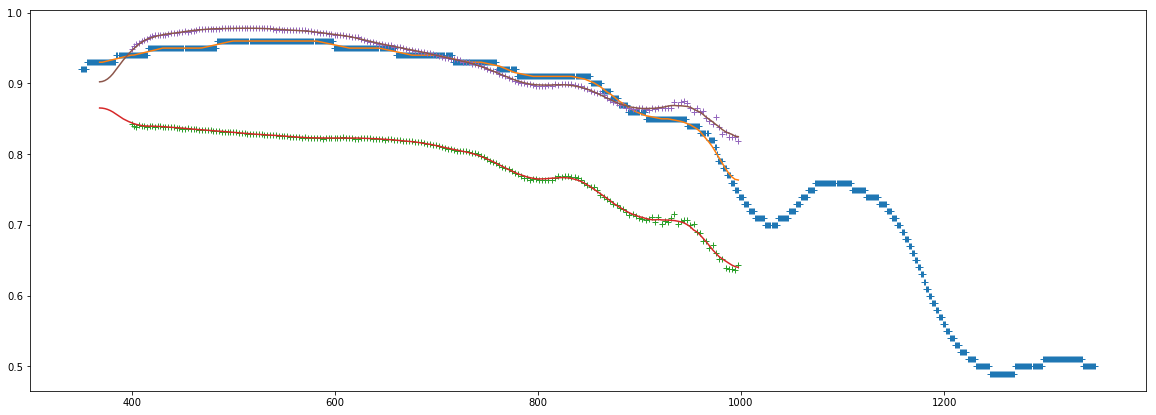

In [16]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots(figsize=(20,7))

spectra_nd = np.empty((len(ice.bands.centers),len(fileList)))

target = []
date = []
location = []
name = []

for k, fn in enumerate(fileList):
    
    # Read spectra
    spectra = envi.open(fn)

    # Extract metadata and store in lists for later use
    metadata = parse_filename(fn)
    target.append(metadata['surface_type'])
    date.append(metadata['date'].strftime('%Y%m%d'))
    location.append(metadata['site'])
    name.append('SNOW [{:s}] {:s}'.format(metadata['surface_type'], metadata['date'].strftime('%Y%m%d')))
    
    # Define linear interpolation function
    f = interp1d(spectra.bands.centers, spectra.spectra.reshape(-1), 
                 bounds_error=False, fill_value='extrapolate')

    # Plot data for checking
    ax.plot(spectra.bands.centers, spectra.spectra.reshape(-1), '+')
    ax.plot(ice.bands.centers, moving_average( f(ice.bands.centers), 11 ), '-')

    # Save interpolated and smoothed spectra to numpy array
    spectra_nd[:,k] = moving_average( f(ice.bands.centers), 11 )
    

## Write to spectral library file

In [ ]:
from spectral.io.envi import SpectralLibrary, gen_params
from shebaspectral import generate_library_header

header = generate_library_header(spectra_nd, ice.bands.centers, target=target, date=date, 
                                 location=location, name=name)
params = gen_params(header)

from spectral.io.envi import SpectralLibrary
specLib = SpectralLibrary(spectra_nd, header, params)

SNOW_LIBRARY_PATH = '..\data\Sheba.SpectralLibrary.snow.filled'
specLib.save(SNOW_LIBRARY_PATH)
